# Case Study- Open Food Factory 

Develop a machine learning solution that automates the extraction of nutritional information from product images. The solution will involve exploratory data analysis (EDA) on product data, design of a modular ML pipeline (including pseudocode), and address challenges in product matching between datasets.


## Libraries

In [1]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import defaultdict
import os
import numpy as np
import cv2
import yaml

## Data

### Reading the Data

In [2]:
df = pd.read_csv(r"C:\Users\inesad00\Downloads\en.openfoodfacts.org.products.csv\en.openfoodfacts.org.products.csv", sep='\t',on_bad_lines='skip')
print(f"The number of rows in the DataFrame is: {df.shape[0]}")

C:\Users\inesad00\AppData\Local\Temp\ipykernel_18412\1130488704.py:1: DtypeWarning: Columns (0,11,17,31,32,33,34,35,45,46,50,52,53,56,67,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\inesad00\Downloads\en.openfoodfacts.org.products.csv\en.openfoodfacts.org.products.csv", sep='\t',on_bad_lines='skip')


The number of rows in the DataFrame is: 3427907


### Sampling the data as the food is larger in size

In [3]:
df_sample = df[:50000]

## Utlity Functions

In [4]:
# Function to fetch image from URL and decode it without saving locally
def fetch_image_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        # Convert the response content to a numpy array and decode it into an image
        image = np.array(bytearray(response.content), dtype=np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        
        # Check if image was successfully downloaded and decoded
        if image is None:
            print(f"Failed to decode image from {url}")
            return None
        return image
    else:
        print(f"Failed to download image from {url}")
        return None

# Function to plot color histograms
def plot_color_histogram(image):
    channels = cv2.split(image)
    colors = ('b', 'g', 'r')
    plt.figure()
    plt.title("Color Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Number of Pixels")
    
    # Plot histogram for each color channel
    for channel, color in zip(channels, colors):
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    
    plt.show()

# Function to plot image size distribution
def plot_image_size_distribution(image_sizes):
    widths, heights = zip(*image_sizes)
    plt.figure()
    plt.title("Image Size Distribution")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.scatter(widths, heights)
    plt.show()

# Function to plot overall pixel intensity distribution
def plot_pixel_distribution(all_pixels):
    plt.figure()
    plt.title("Overall Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    # Flatten all pixel intensities and plot histogram
    all_pixels = np.concatenate(all_pixels, axis=None)
    plt.hist(all_pixels, bins=256, color='gray', alpha=0.7)
    plt.xlim([0, 256])
    plt.show()

In [5]:
def plot_top_items(data, column, title, count = True):
    # Count occurrences of each item
    if count:
        item_count = data[column].value_counts().reset_index()
        item_count.columns = [column, 'count']
    else:
        item_count = data.sort_values(by='count', ascending=False)

    # Get the top 20 items
    top_20_items = item_count.head(20)

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(top_20_items[column], top_20_items['count'], color='skyblue')
    plt.xlabel('Count')
    plt.title(title)
    plt.gca().invert_yaxis()  # To display the highest count at the top

    # Descriptive statistics
    stats = item_count['count'].describe()

    # Annotate the plot with statistics in the lower right corner
    stats_text = (f"Count Statistics:\n"
                  f"Count: {stats['count']:.0f}\n"
                  f"Mean: {stats['mean']:.2f}\n"
                  f"Std: {stats['std']:.2f}\n"
                  f"Min: {stats['min']:.0f}\n"
                  f"25%: {stats['25%']:.0f}\n"
                  f"50%: {stats['50%']:.0f}\n"
                  f"75%: {stats['75%']:.0f}\n"
                  f"Max: {stats['max']:.0f}")

    plt.text(0.95, 0.05, stats_text, ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightgrey', alpha=0.5))

    plt.show()

In [6]:
# Assuming 'image_url' is the column name in your DataFrame that contains the URLs
def plot_sample_images(df, url_column, sample_size=5):
    # Randomly sample URLs from the DataFrame
    sample_urls = df[url_column].dropna().sample(n=sample_size).values

    # Plot images in subplots
    fig, axes = plt.subplots(1, sample_size, figsize=(20, 5))

    for i, url in enumerate(sample_urls):
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


## Exploratory Data Analysis

In [7]:
categories_df = df_sample["categories"].value_counts().reset_index()
categories_df

categories  count
0                                                Snacks   1798
1                 Snacks, Sweet snacks, Confectioneries    971
2                         Condiments, Sauces, Groceries    831
3                                          Frozen foods    745
4     Dairies, Fermented foods, Fermented milk produ...    682
...                                                 ...    ...
4017  Aliments et boissons à base de végétaux, Boiss...      1
4018  Petit-déjeuners, Produits à tartiner, Produits...      1
4019  Aliments et boissons à base de végétaux, Alime...      1
4020   Tartes sucrées, Tartes, Tartes à la noix de coco      1
4021  Plant-based foods and beverages, Plant-based f...      1

[4022 rows x 2 columns]

In [8]:
single_labled_categories_df = categories_df[~categories_df["categories"].str.contains(",")]
multi_labled_categories_df = categories_df[categories_df["categories"].str.contains(",")]

In [9]:
single_labled_categories_df

categories  count
0                 Snacks   1798
3           Frozen foods    745
9          Salted snacks    506
20    Baking decorations    237
22       Cooking helpers    216
...                  ...    ...
4006      Taco Seasoning      1
4010           Calissons      1
4011           seasoning      1
4012        veganes hack      1
4014          en:popcorn      1

[743 rows x 2 columns]

In [10]:
multi_labled_categories_df

categories  count
1                 Snacks, Sweet snacks, Confectioneries    971
2                         Condiments, Sauces, Groceries    831
4     Dairies, Fermented foods, Fermented milk produ...    682
5     Snacks, Sweet snacks, Biscuits and cakes, Bisc...    639
6     Plant-based foods and beverages, Plant-based f...    573
...                                                 ...    ...
4017  Aliments et boissons à base de végétaux, Boiss...      1
4018  Petit-déjeuners, Produits à tartiner, Produits...      1
4019  Aliments et boissons à base de végétaux, Alime...      1
4020   Tartes sucrées, Tartes, Tartes à la noix de coco      1
4021  Plant-based foods and beverages, Plant-based f...      1

[3279 rows x 2 columns]

In [11]:
processed = df_sample.drop(columns=['created_t','created_datetime','last_updated_t','last_modified_t','last_modified_datetime','last_modified_datetime','last_updated_datetime'])

Columns related to 'created': ['created_t', 'created_datetime']
Columns related to 'last': ['last_modified_t', 'last_modified_datetime', 'last_modified_by', 'last_updated_t', 'last_updated_datetime', 'last_image_t', 'last_image_datetime']
Columns related to 'product': ['product_name', 'product_quantity']
Columns related to 'packaging': ['packaging', 'packaging_tags', 'packaging_en', 'packaging_text']
Columns related to 'brands': ['brands', 'brands_tags']
Columns related to 'categories': ['categories', 'categories_tags', 'categories_en']
Columns related to 'origins': ['origins', 'origins_tags', 'origins_en']
Columns related to 'manufacturing': ['manufacturing_places', 'manufacturing_places_tags']
Columns related to 'labels': ['labels', 'labels_tags', 'labels_en']
Columns related to 'emb': ['emb_codes', 'emb_codes_tags']
Columns related to 'cities': ['cities', 'cities_tags']
Columns related to 'countries': ['countries', 'countries_tags', 'countries_en']
Columns related to 'ingredients': 

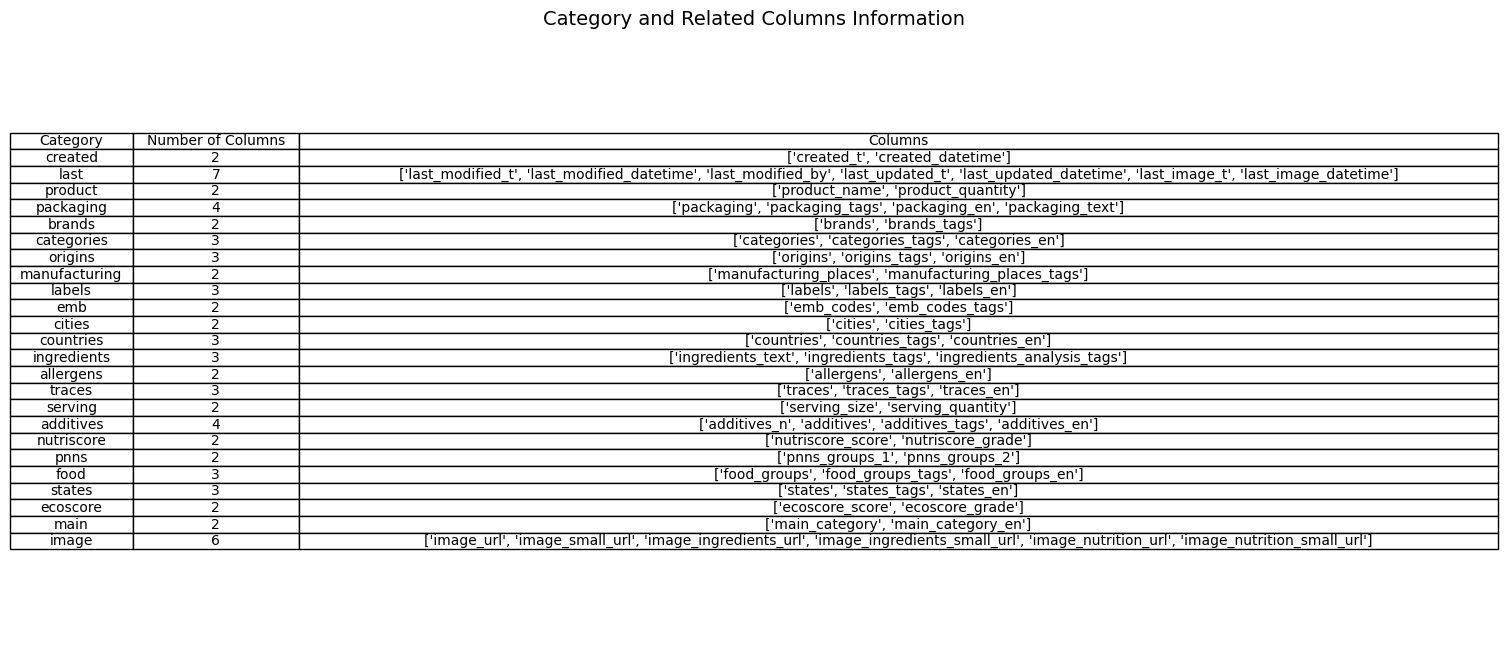

In [12]:
# Get all column names
columns = df.columns.tolist()

# Initialize a dictionary to store similar columns
similar_columns = defaultdict(list)

# Group columns based on their substrings
for col in columns:
    # Use a common substring for grouping (e.g., splitting by underscores)
    key = col.split('_')[0]  # You can adjust the logic as needed
    similar_columns[key].append(col)

# Remove keys with only one column (if desired)
similar_columns = {k: v for k, v in similar_columns.items() if len(v) > 1}

# Display similar columns
for key, value in similar_columns.items():
    print(f"Columns related to '{key}': {value}")

# Convert dictionary to DataFrame
df = pd.DataFrame([(key, len(value), value) for key, value in similar_columns.items()],
                  columns=['Category', 'Number of Columns', 'Columns'])

# Plot the table in a graph
fig, ax = plt.subplots(figsize=(12, 8))  # Set figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Auto-adjust column width
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))

# Show the table as a graph
plt.title('Category and Related Columns Information', fontsize=14)
plt.show()

In [13]:
req_cols = list(processed.loc[:,'energy-kj_100g':].columns)
req_cols.extend(('categories_en', 'brands_tags', 'allergens_en', 'serving_quantity', 'ingredients_tags', 'image_ingredients_url', 'image_nutrition_url'))


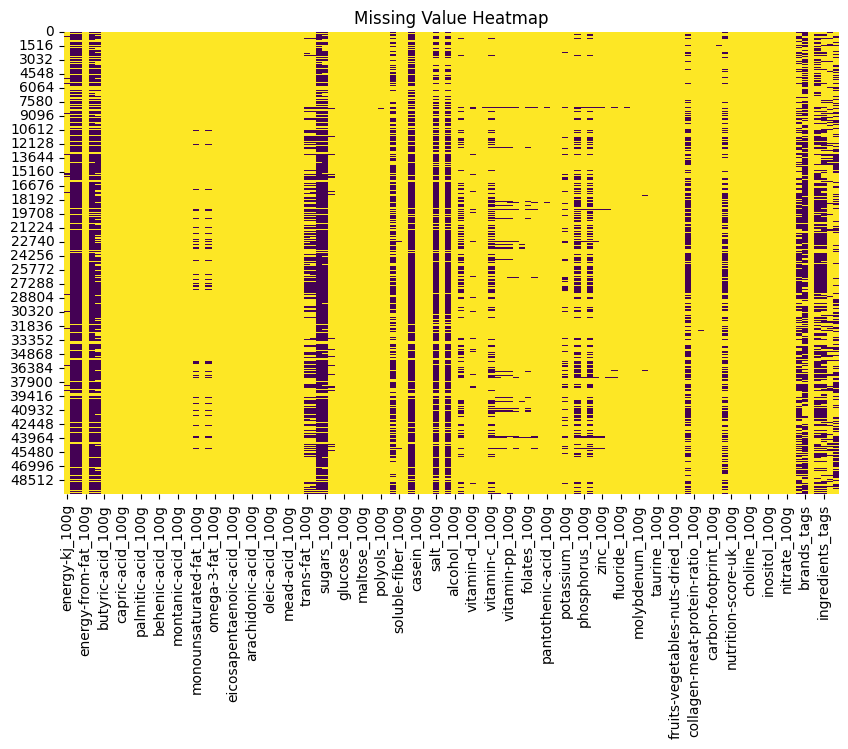

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(processed[req_cols].isnull(), cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.show()

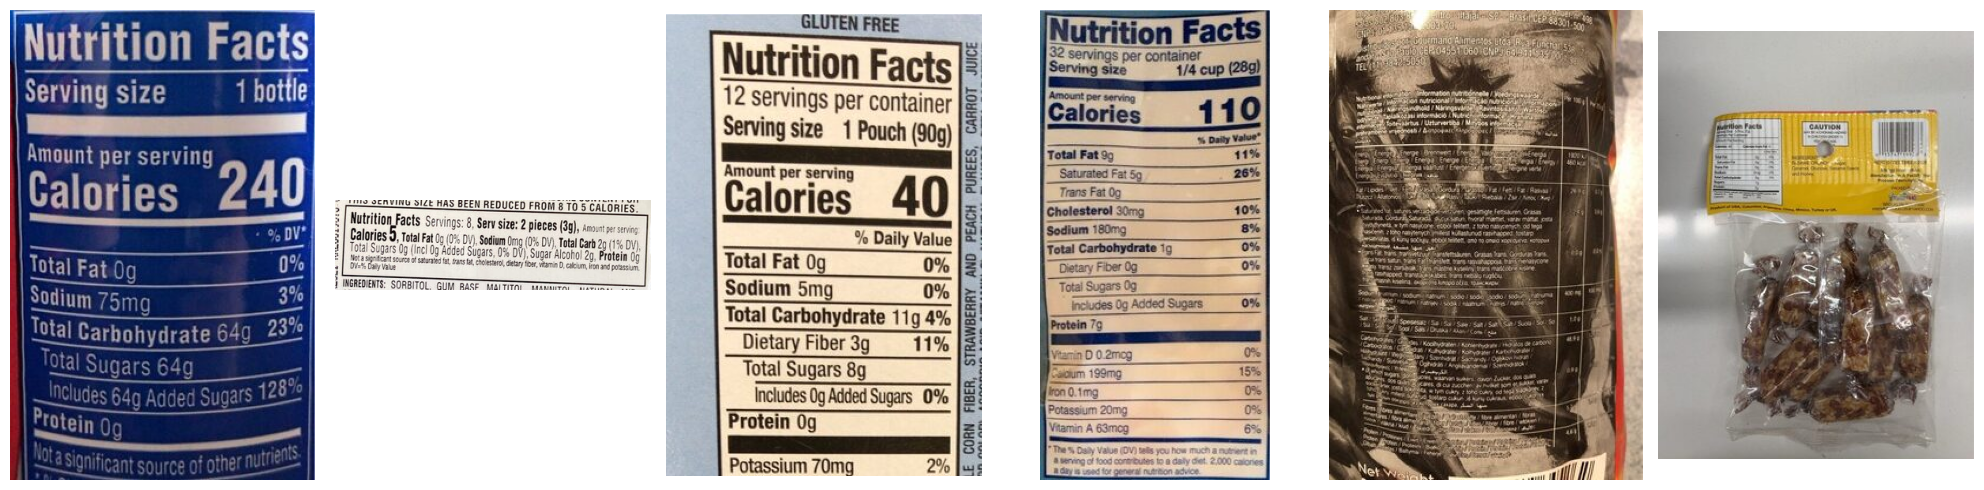

In [17]:
plot_sample_images(df_sample[~df_sample['image_nutrition_url'].isna()], 'image_nutrition_url', sample_size=6)

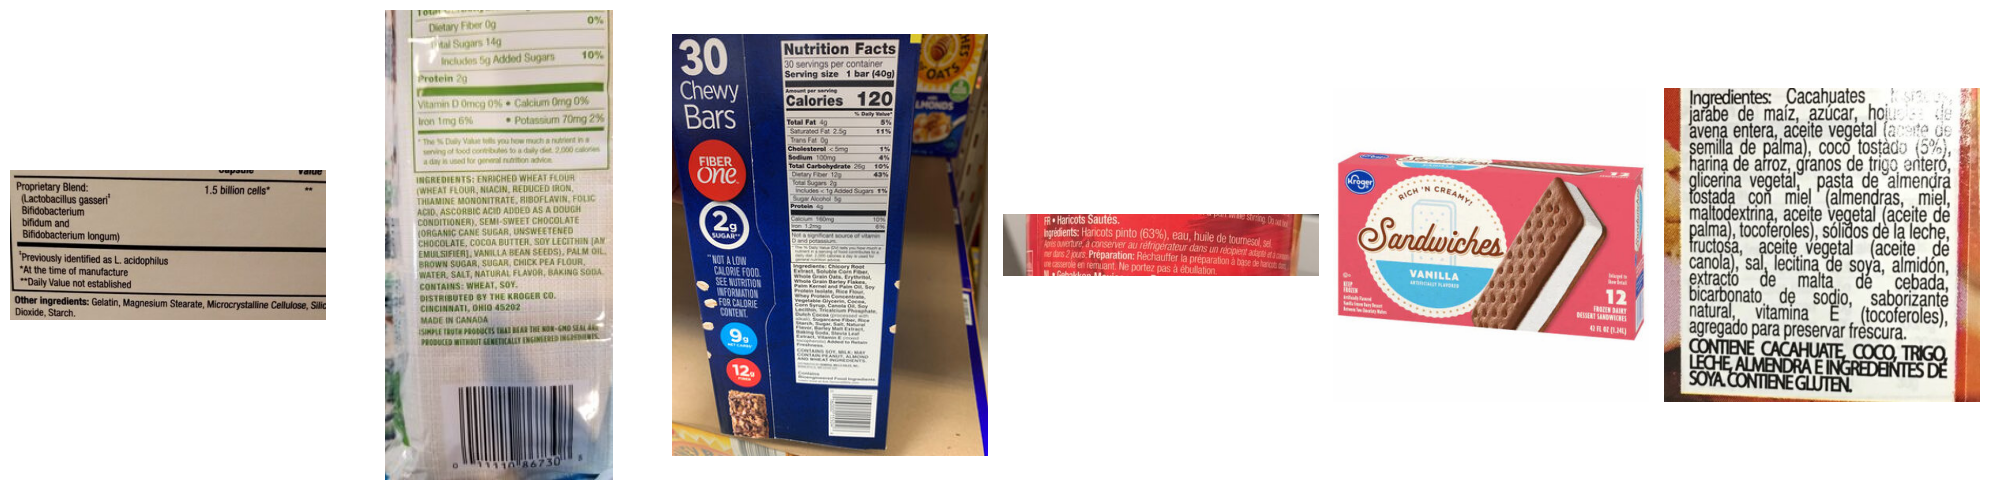

In [ ]:
plot_sample_images(df_sample[~df_sample['image_ingredients_url'].isna()], 'image_ingredients_url', sample_size=6)

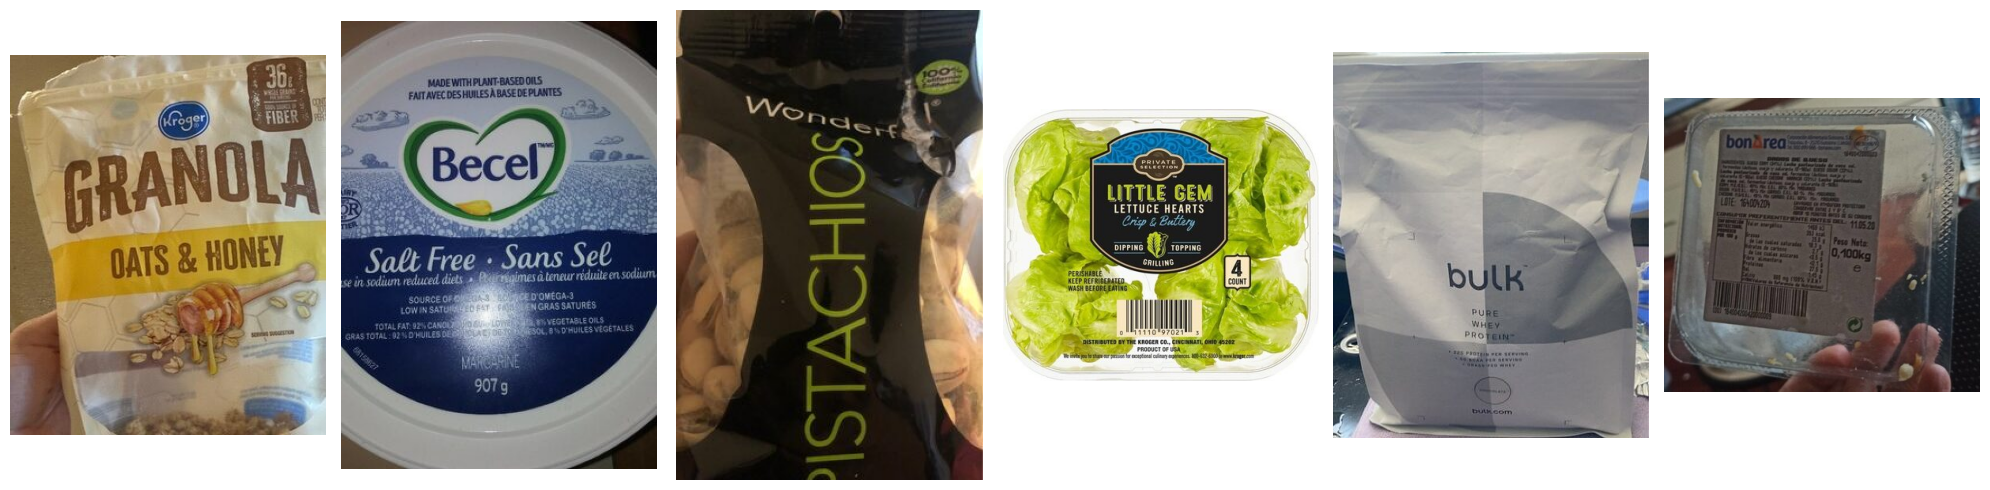

In [ ]:

plot_sample_images(df_sample[~df_sample['image_url'].isna()], 'image_url', sample_size=6)

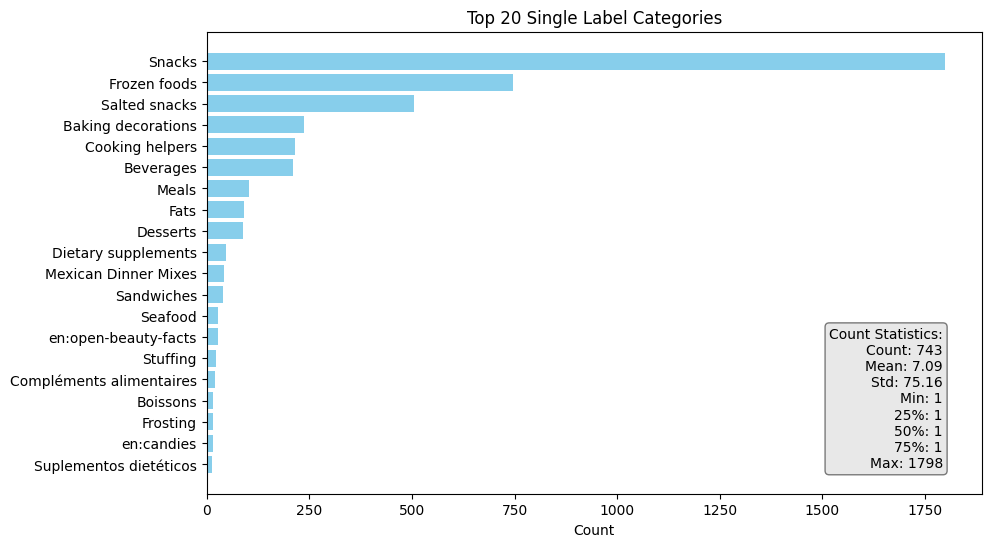

In [ ]:
# Example usage:
plot_top_items(single_labled_categories_df, 'categories', 'Top 20 Single Label Categories',count = False)

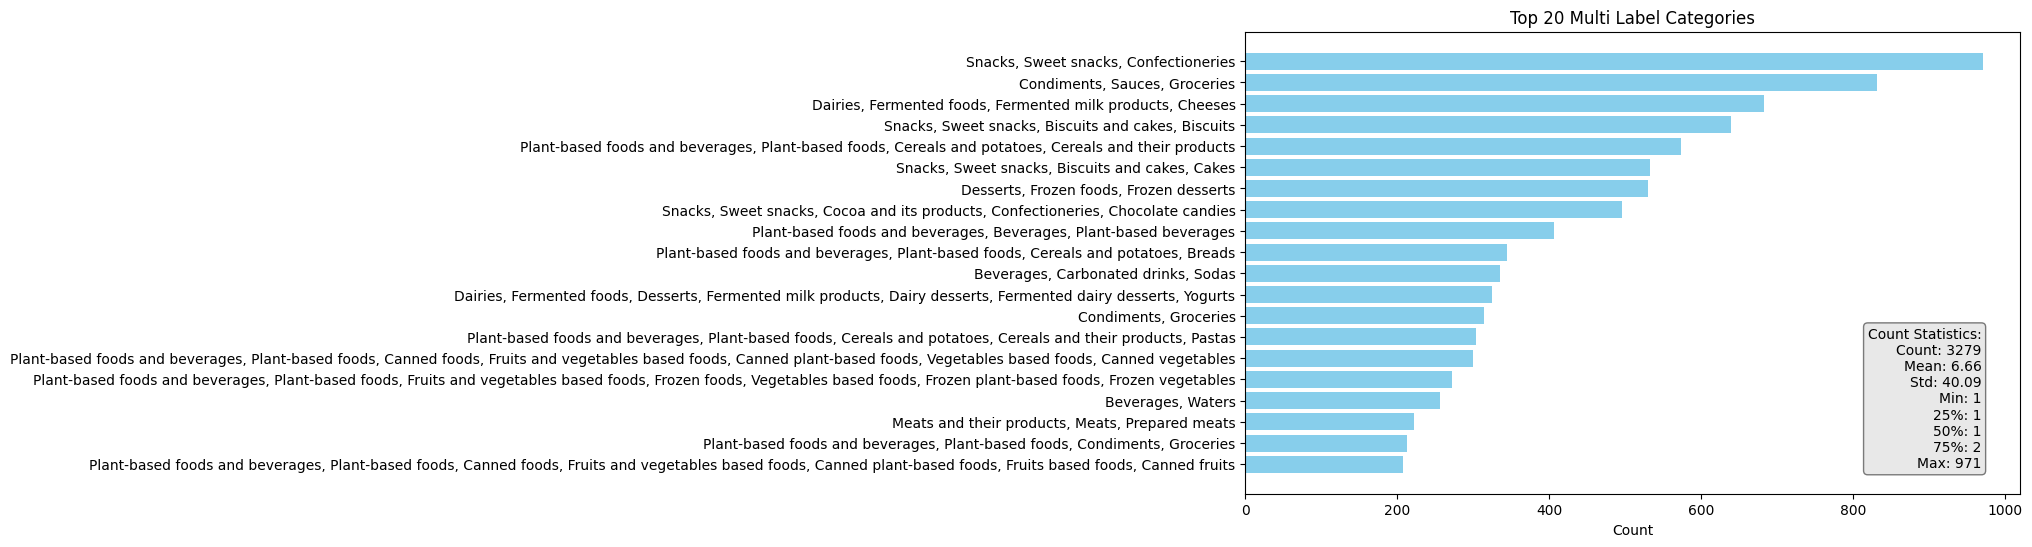

In [ ]:
# Example usage:
plot_top_items(multi_labled_categories_df, 'categories', 'Top 20 Multi Label Categories',count = False)

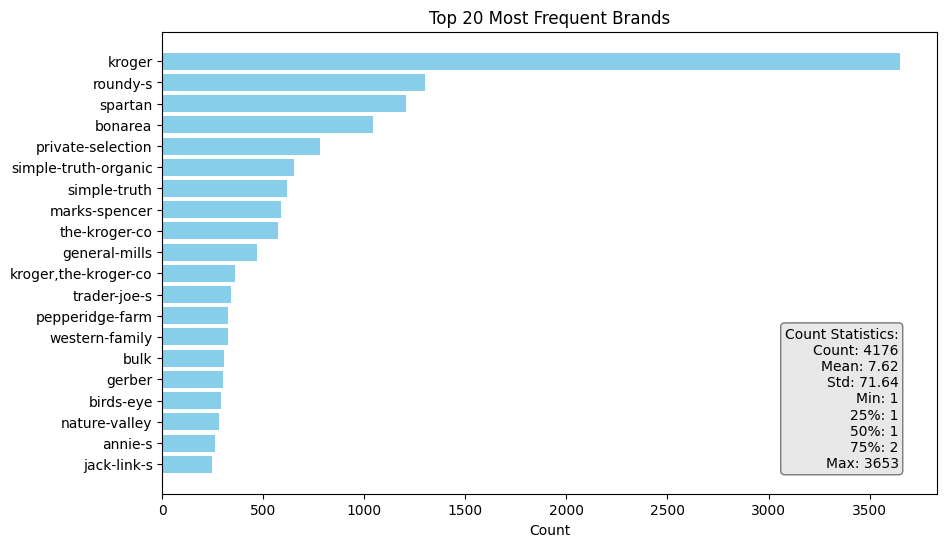

In [ ]:
# Example usage:
plot_top_items(processed, 'brands_tags', 'Top 20 Most Frequent Brands')

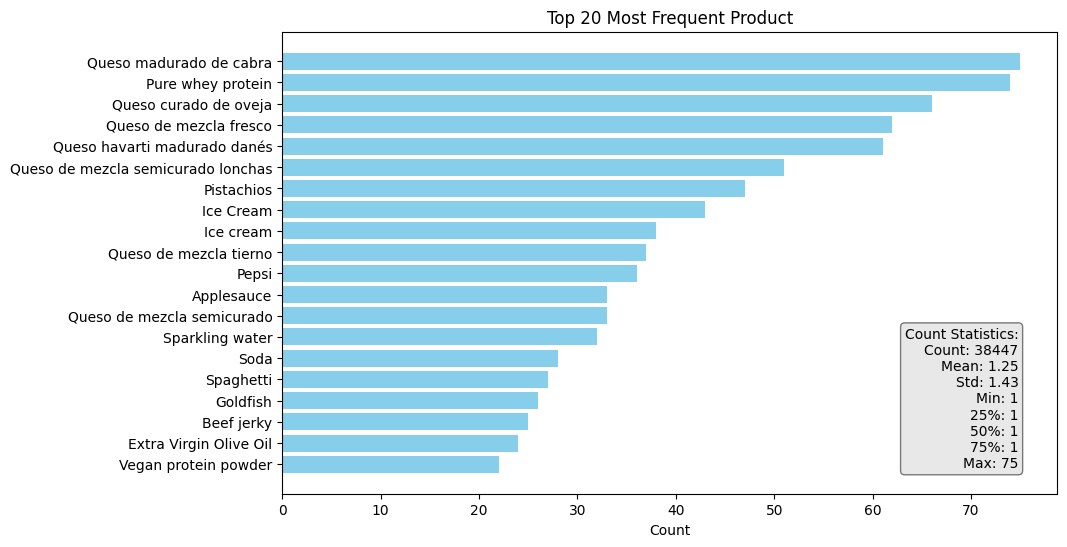

In [ ]:
plot_top_items(processed, 'product_name', 'Top 20 Most Frequent Product')

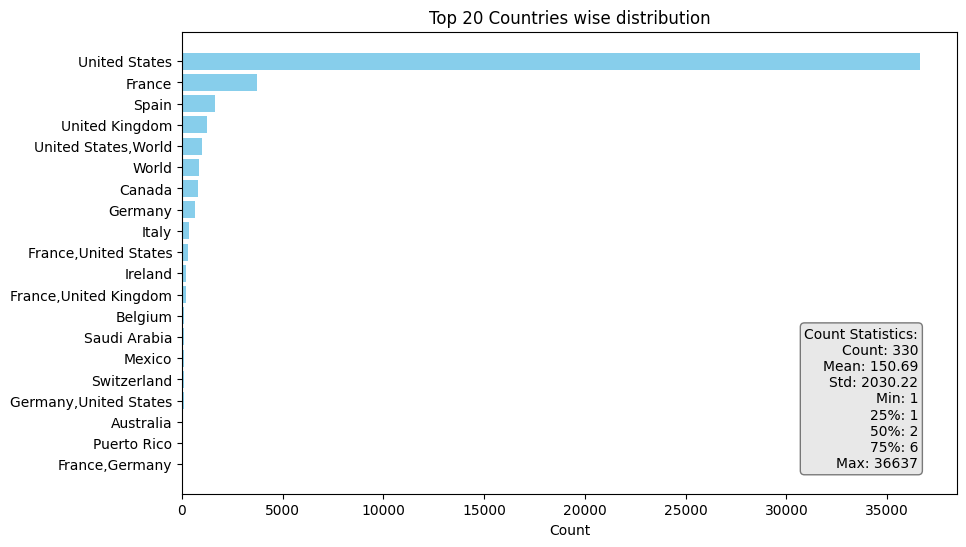

In [ ]:
plot_top_items(processed, 'countries_en', 'Top 20 Countries wise distribution')


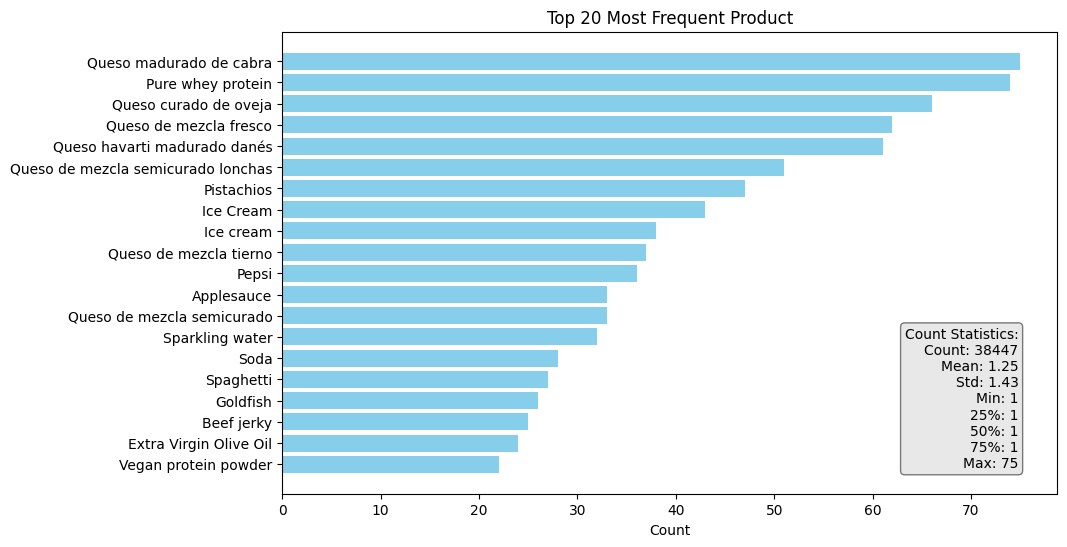

In [ ]:
plot_top_items(processed, 'product_name', 'Top 20 Most Frequent Product')

In [ ]:
data = processed.loc[:,'energy_100g':]
wide_nutritions = data.columns
# Define nutrient buckets
config_path = 'config/configuration.yaml'

# Load configuration
config = load_config(config_path)
nutrient_buckets = config['nutrient_buckets']

# Create new features in the DataFrame based on nutrient buckets
for category, nutrients in nutrient_buckets.items():
    for nutrient, columns in nutrients.items():
        # Calculate the sum of each nutrient category
        data[f'{nutrient}_sum'] = data[columns].sum(axis=1, skipna=True)

In [ ]:
bucketed = data.drop(columns = wide_nutritions)
correlation_matrix = bucketed.corr()

In [ ]:
stats = bucketed.describe()
stats

Energy_sum      Fats_sum  Proteins_sum  Carbohydrates_sum  \
count   50000.000000  50000.000000  50000.000000       50000.000000   
mean     1005.315410     15.532578      7.986357          28.655480   
std      2710.257397     52.751880     40.005844          62.425945   
min         0.000000      0.000000      0.000000           0.000000   
25%       163.000000      0.000000      0.000000           1.000000   
50%       895.000000      3.220000      3.508772          14.285714   
75%      1590.000000     21.000000      9.523810          53.570000   
max    317984.000000   5815.714400   5000.000000        7700.000000   

       Vitamins_sum  Minerals_sum  Fatty Acids_sum  Other Nutrients_sum  \
count  50000.000000  50000.000000     50000.000000         50000.000000   
mean       0.032707      0.091130         0.000200             0.000086   
std        1.609445      1.246557         0.031201             0.010043   
min        0.000000      0.000000         0.000000             0.000000   
25%        0.000000      0.000000         0.000000             0.000000   
50%        0.000000      0.000000         0.000000             0.000000   
75%        0.000000      0.031075         0.000000             0.000000   
max      231.400000    185.037512         5.710000             1.670000   

       Other Factors_sum  
count       50000.000000  
mean            4.290120  
std             7.591007  
min           -14.000000  
25%             0.000000  
50%             0.000000  
75%            10.000000  
max            40.000000

Text(120.72222222222221, 0.5, 'Statistics')

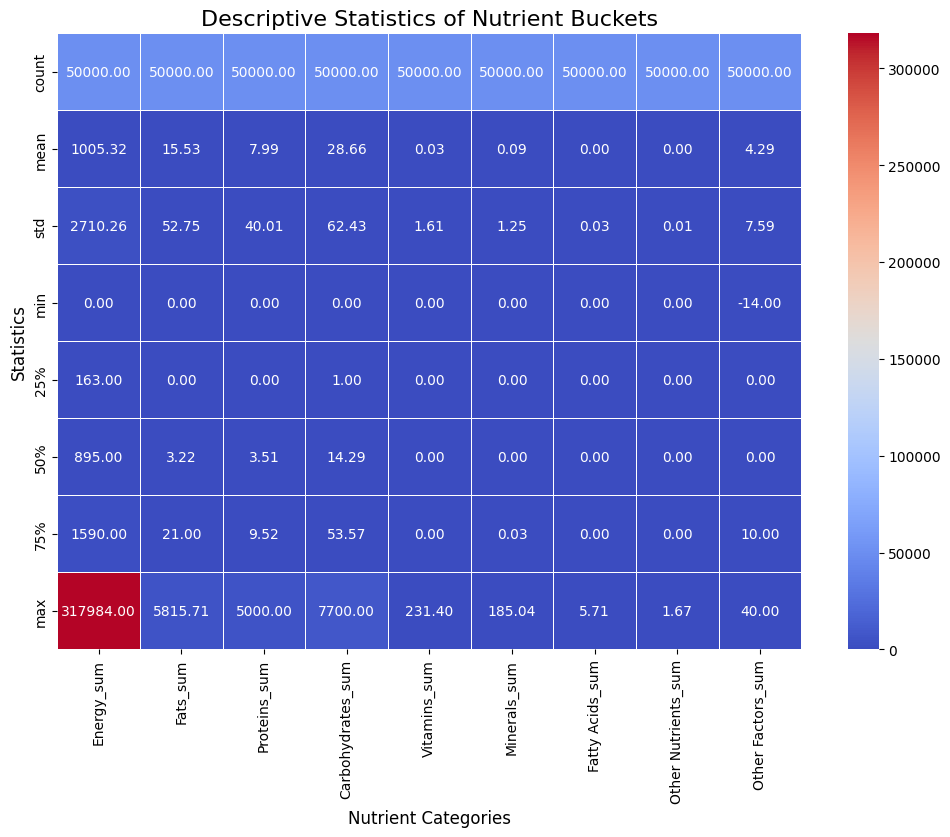

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(stats, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set plot labels and title
plt.title('Descriptive Statistics of Nutrient Buckets', fontsize=16)
plt.xlabel('Nutrient Categories', fontsize=12)
plt.ylabel('Statistics', fontsize=12)

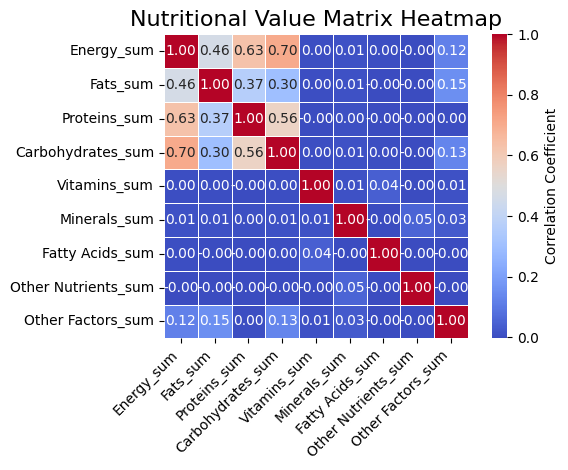

In [ ]:
sns.heatmap(correlation_matrix, 
            annot=True,        # Show correlation coefficients
            fmt=".2f",        # Format for annotation
            cmap='coolwarm',  # Color map
            cbar_kws={'label': 'Correlation Coefficient'},  # Color bar label
            square=True,      # Make the heatmap square-shaped
            linewidths=0.5,  # Lines between cells
            linecolor='white') # Line color
plt.title('Nutritional Value Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

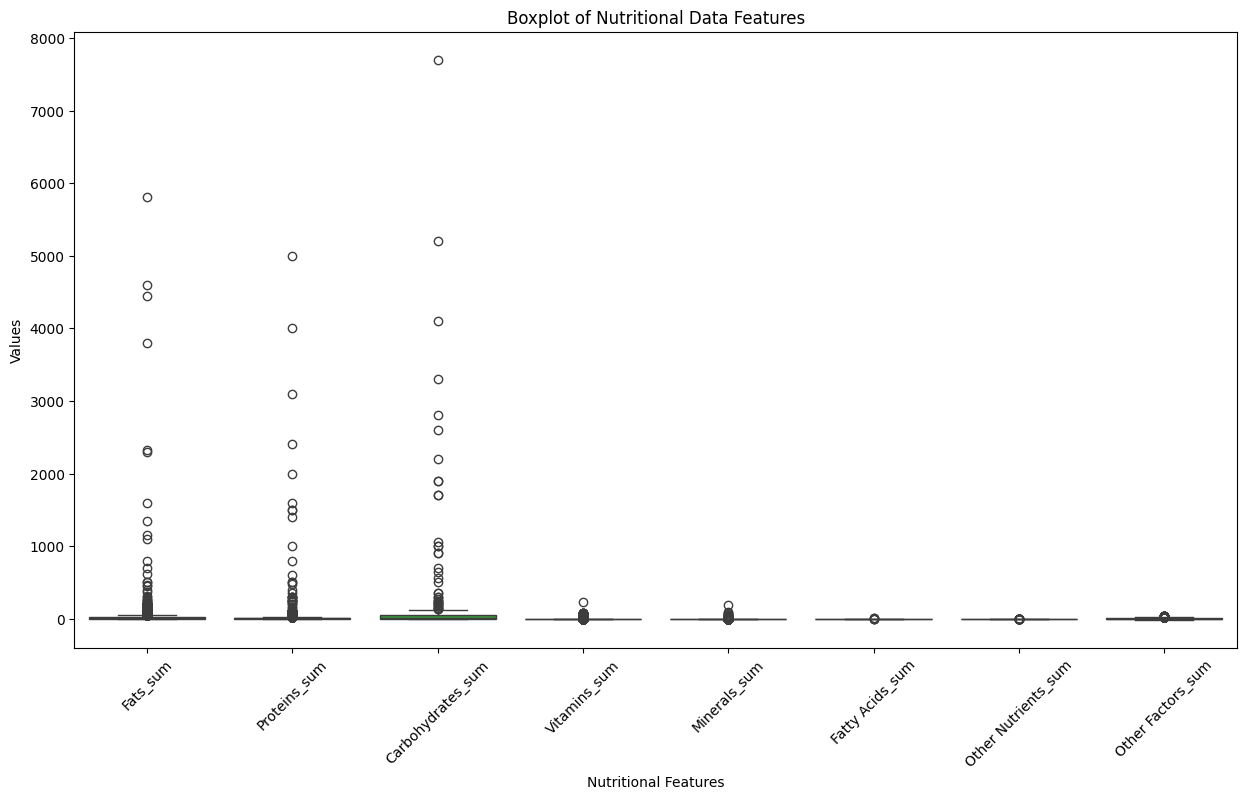

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=bucketed.iloc[:,1:])

# Adding labels
plt.title("Boxplot of Nutritional Data Features")
plt.xticks(rotation=45)
plt.xlabel("Nutritional Features")
plt.ylabel("Values")

# Display the plot
plt.show()

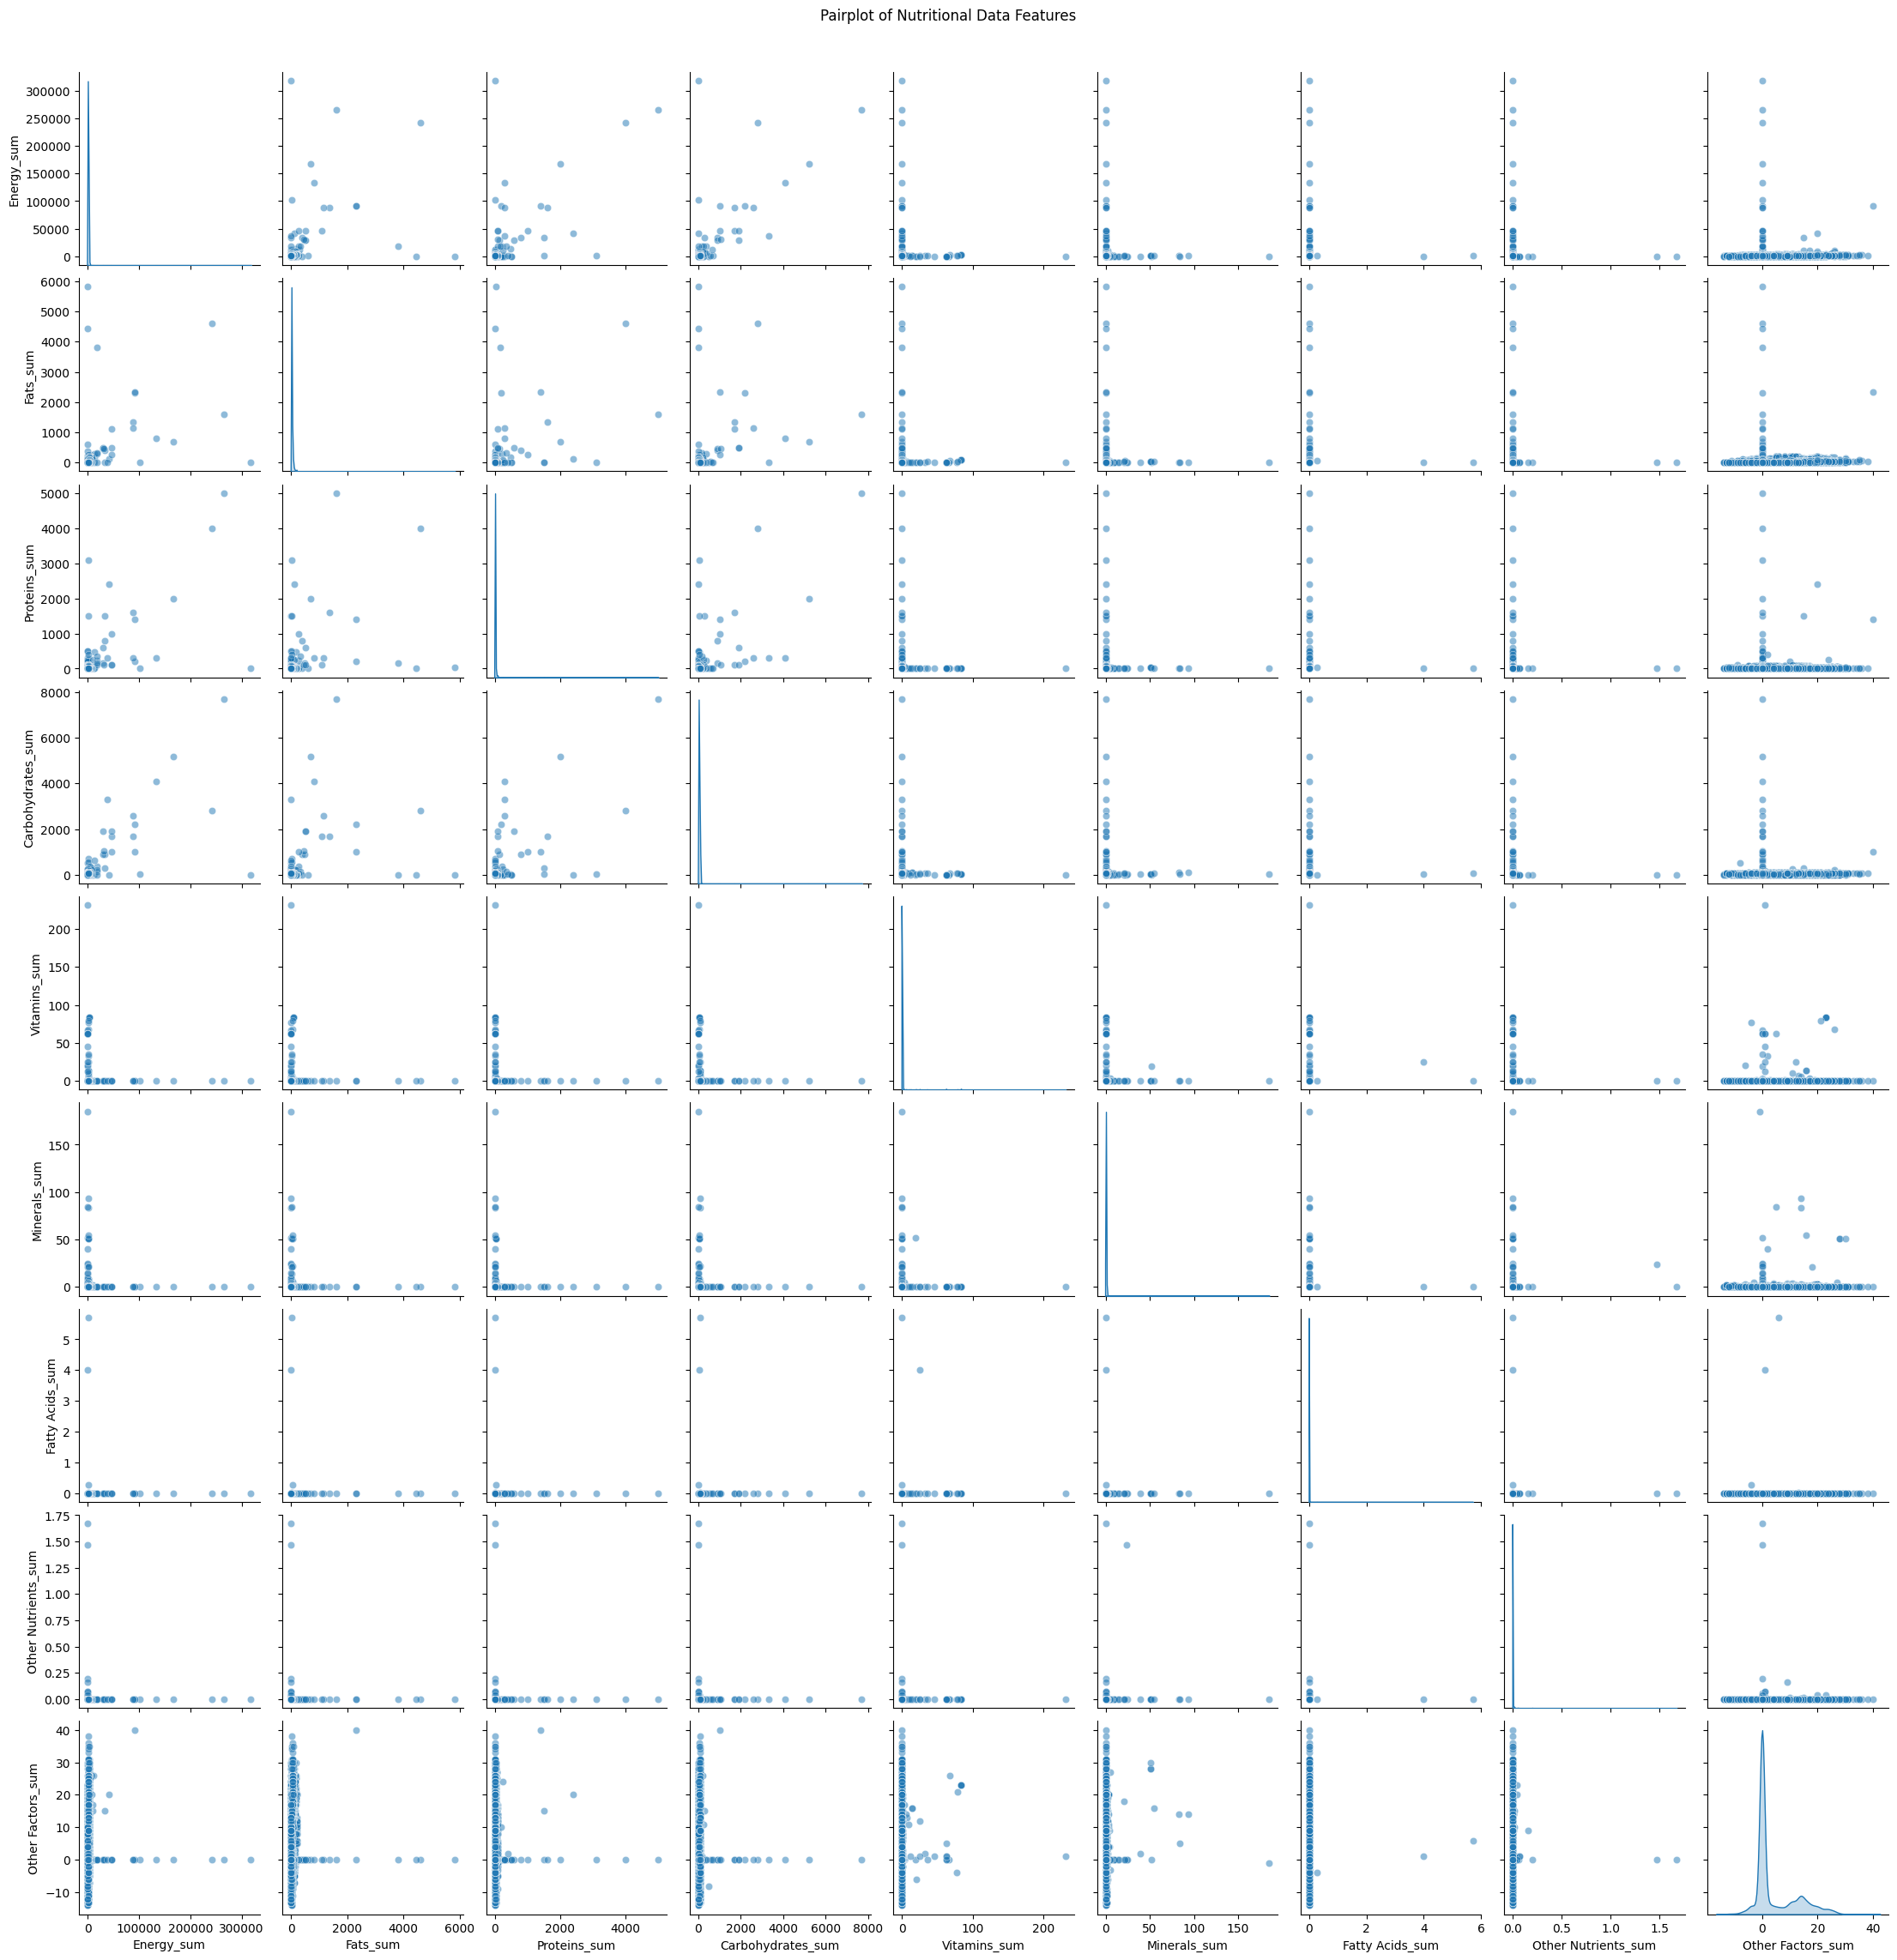

In [ ]:
sns.pairplot(bucketed, diag_kind='kde', plot_kws={'alpha':0.5})

# Adding a title to the overall plot
plt.suptitle("Pairplot of Nutritional Data Features", y=1.02)

# Display the plot
plt.show()

Image 1 fetched successfully from: https://images.openfoodfacts.org/images/products/000/000/000/0000207025004/nutrition_de.3.400.jpg
Image 2 fetched successfully from: https://images.openfoodfacts.org/images/products/000/000/000/00003429145/nutrition_es.7.400.jpg
Image 3 fetched successfully from: https://images.openfoodfacts.org/images/products/000/000/000/00026772226/nutrition_fr.5.400.jpg
Image 4 fetched successfully from: https://images.openfoodfacts.org/images/products/000/000/000/003327986/nutrition_es.5.400.jpg
Image 5 fetched successfully from: https://images.openfoodfacts.org/images/products/000/000/000/004128579/nutrition_es.5.400.jpg
Image 6 fetched successfully from: https://images.openfoodfacts.org/images/products/000/000/000/004622327/nutrition_es.5.400.jpg
Image 7 fetched successfully from: https://images.openfoodfacts.org/images/products/000/000/000/006021/nutrition_en.5.400.jpg
Image 8 fetched successfully from: https://images.openfoodfacts.org/images/products/000/000/

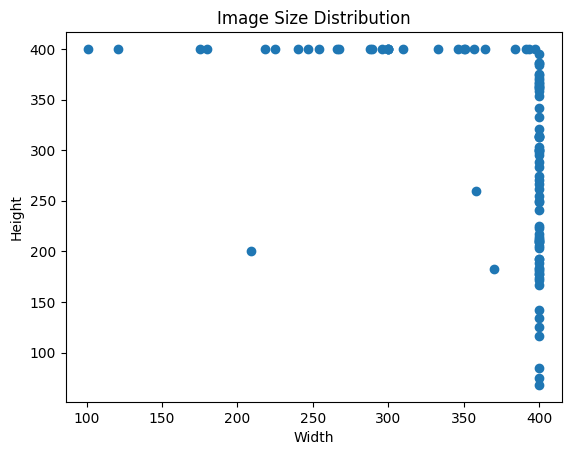

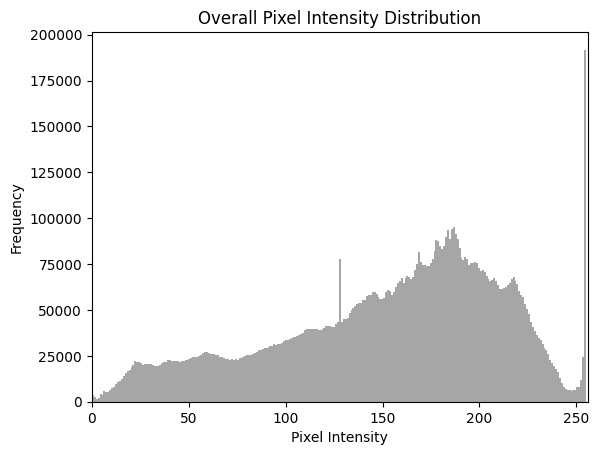

In [16]:
# ---- Execution ----

# List of image URLs
url_list = df_sample[~df_sample['image_nutrition_url'].isna()]['image_nutrition_url'][:100].to_list()

# Lists to store image sizes and pixel intensities across all images
image_sizes = []
all_pixels = []

# Iterate through each URL, fetch the image, and analyze it
for index, url in enumerate(url_list):
    image = fetch_image_from_url(url)

    if image is not None:
        print(f"Image {index+1} fetched successfully from: {url}")
        
        # Step 1: Store image size (width, height)
        height, width, _ = image.shape
        image_sizes.append((width, height))

        # Step 2: Flatten pixel values (grayscale version) and store
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        all_pixels.append(gray_image.flatten())

# Step 3: Plot image size distribution (code from before)
plot_image_size_distribution(image_sizes)

# Step 4: Plot pixel intensity distribution (code from before)
plot_pixel_distribution(all_pixels)